In [1]:
# Step 1: Load the dataset
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
df = pd.read_csv("creditcard.csv")
print("Shape of dataset:", df.shape)

# Check and handle missing values
print("Missing values:\n", df.isnull().sum().sum())

# Standardize 'Amount' feature
df['normAmount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df = df.drop(['Time', 'Amount'], axis=1)

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Shape of dataset: (284807, 31)
Missing values:
 0


In [5]:
# Step 2: Apply SMOTE for class imbalance
from imblearn.over_sampling import SMOTE

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Display new class distribution
print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Class
0    227451
1       394
Name: count, dtype: int64
After SMOTE: Class
0    227451
1    227451
Name: count, dtype: int64


In [9]:
# Step 3: Train baseline XGBoost model
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay

baseline_model = XGBClassifier(eval_metric='logloss', random_state=42)
baseline_model.fit(X_train_res, y_train_res)

# Predict on test set
y_pred_baseline = baseline_model.predict(X_test)
y_proba_baseline = baseline_model.predict_proba(X_test)[:,1]

# Evaluate
print("=== Baseline Model Performance ===")
# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay
print("Accuracy:", accuracy_score(y_test, y_pred_baseline))
print("Precision:", precision_score(y_test, y_pred_baseline))
print("Recall:", recall_score(y_test, y_pred_baseline))
print("F1 Score:", f1_score(y_test, y_pred_baseline))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_baseline))


=== Baseline Model Performance ===
Accuracy: 0.9990871107053826
Precision: 0.6854838709677419
Recall: 0.8673469387755102
F1 Score: 0.7657657657657657
ROC-AUC Score: 0.9752791838457386


In [11]:
!pip install deap

In [13]:
import random
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score

# Create scorer
f1 = make_scorer(f1_score)

# GA setup
num_features = X_train_res.shape[1]
X_array = X_train_res.values
y_array = y_train_res.values

# Create fitness and individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximize F1
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=num_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def eval_fitness(individual):
    if sum(individual) == 0:
        return 0.0,
    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    X_selected = X_array[:, selected_features]
    model = XGBClassifier(eval_metric='logloss', random_state=42)
    scores = cross_val_score(model, X_selected, y_array, cv=3, scoring=f1)
    return scores.mean(),

toolbox.register("evaluate", eval_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


In [15]:
# Run GA
random.seed(42)
pop = toolbox.population(n=20)
hof = tools.HallOfFame(1)  # Best individual
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, 
                                   stats=stats, halloffame=hof, verbose=True)

# Best features
best_features = [i for i, bit in enumerate(hof[0]) if bit == 1]
print("Selected Features Indices:", best_features)

# Update dataset
X_train_selected = X_train_res.iloc[:, best_features]
X_test_selected = X_test.iloc[:, best_features]

gen	nevals	avg     	max     
0  	20    	0.998904	0.999488
1  	13    	0.99934 	0.999521
2  	12    	0.999385	0.999508
3  	11    	0.999435	0.999508
4  	13    	0.999469	0.999541
5  	7     	0.999511	0.999563
6  	11    	0.999528	0.999541
7  	4     	0.999541	0.999585
8  	10    	0.999544	0.999585
9  	13    	0.999545	0.999585
10 	11    	0.999558	0.999585
Selected Features Indices: [0, 2, 3, 6, 7, 10, 12, 13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28]


In [17]:
!pip install optuna deap pyswarm

In [19]:
#Hybrid optimization for Hyper Parameter tuning - Bayesian Optimization
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-4, 1.0)
    }
    model = XGBClassifier(eval_metric='logloss', **params)
    score = cross_val_score(model, X_train_selected, y_train_res, cv=3, scoring='f1').mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best from Bayesian Optimization:", study.best_params)
bo_best = study.best_params

[I 2025-04-21 20:47:06,845] A new study created in memory with name: no-name-6bc74943-c72a-4826-b94c-daacf61745f1
[I 2025-04-21 20:47:16,288] Trial 0 finished with value: 0.9985815622122852 and parameters: {'max_depth': 5, 'learning_rate': 0.21520117339383113, 'n_estimators': 99, 'subsample': 0.7195523207922648, 'colsample_bytree': 0.7496307146774775, 'gamma': 0.02154310274084213}. Best is trial 0 with value: 0.9985815622122852.
[I 2025-04-21 20:47:22,121] Trial 1 finished with value: 0.9518588453046944 and parameters: {'max_depth': 4, 'learning_rate': 0.01493730227821411, 'n_estimators': 57, 'subsample': 0.7864210065138388, 'colsample_bytree': 0.795189349163367, 'gamma': 0.6790121128420039}. Best is trial 0 with value: 0.9985815622122852.
[I 2025-04-21 20:47:32,535] Trial 2 finished with value: 0.9980418531708036 and parameters: {'max_depth': 5, 'learning_rate': 0.15082135756950663, 'n_estimators': 116, 'subsample': 0.7930009003939814, 'colsample_bytree': 0.7251997537935969, 'gamma': 

Best from Bayesian Optimization: {'max_depth': 10, 'learning_rate': 0.18725601164386893, 'n_estimators': 233, 'subsample': 0.8172100172441275, 'colsample_bytree': 0.9064574915923714, 'gamma': 0.0036399539020184747}


In [23]:
# Convert best params to a genome and evolve
from deap import base, creator, tools, algorithms

# Define parameter ranges for GA
param_ranges = {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (50, 300),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.6, 1.0),
    'gamma': (1e-4, 1.0)
}

def random_param():
    return [
        random.randint(*param_ranges['max_depth']),
        random.uniform(*param_ranges['learning_rate']),
        random.randint(*param_ranges['n_estimators']),
        random.uniform(*param_ranges['subsample']),
        random.uniform(*param_ranges['colsample_bytree']),
        random.uniform(*param_ranges['gamma'])
    ]

def clamp(val, min_val, max_val):
    return max(min_val, min(val, max_val))

def decode_param(ind):
    return {
        'max_depth': int(clamp(ind[0], 3, 10)),
        'learning_rate': clamp(ind[1], 0.01, 0.3),
        'n_estimators': int(clamp(ind[2], 50, 300)),
        'subsample': clamp(ind[3], 0.6, 1.0),
        'colsample_bytree': clamp(ind[4], 0.6, 1.0),
        'gamma': clamp(ind[5], 1e-4, 1.0)
    }


creator.create("FitnessGA", base.Fitness, weights=(1.0,))
creator.create("IndividualGA", list, fitness=creator.FitnessGA)
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.IndividualGA, random_param)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def fitness_ga(individual):
    params = decode_param(individual)
    model = XGBClassifier(eval_metric='logloss', **params)
    score = cross_val_score(model, X_train_selected, y_train_res, cv=3, scoring='f1').mean()
    return score,

toolbox.register("evaluate", fitness_ga)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

ga_pop = toolbox.population(n=10)
hof = tools.HallOfFame(1)
ga_pop, _ = algorithms.eaSimple(ga_pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=5, halloffame=hof, verbose=True)

ga_best = decode_param(hof[0])
print("Best from GA:", ga_best)


C:\Users\brosh\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessGA' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\brosh\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'IndividualGA' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	10    
1  	8     
2  	8     
3  	5     
4  	3     
5  	9     
Best from GA: {'max_depth': 7, 'learning_rate': 0.19228550185756704, 'n_estimators': 178, 'subsample': 0.9068440002662896, 'colsample_bytree': 0.655060989461341, 'gamma': 0.40233718290343545}


In [25]:
import pyswarms as ps

def pso_fitness(x):
    scores = []
    for i in range(x.shape[0]):
        params = {
            'max_depth': int(x[i][0]),
            'learning_rate': x[i][1],
            'n_estimators': int(x[i][2]),
            'subsample': x[i][3],
            'colsample_bytree': x[i][4],
            'gamma': x[i][5]
        }
        model = XGBClassifier( eval_metric='logloss', **params)
        score = cross_val_score(model, X_train_selected, y_train_res, cv=3, scoring='f1').mean()
        scores.append(-score)  # minimize
    return np.array(scores)

bounds = ([3, 0.01, 50, 0.6, 0.6, 0.0001], [10, 0.3, 300, 1.0, 1.0, 1.0])
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=6, options={'c1': 0.5, 'c2': 0.3, 'w': 0.9}, bounds=bounds)
best_cost, best_pos = optimizer.optimize(pso_fitness, iters=10)

pso_best = {
    'max_depth': int(best_pos[0]),
    'learning_rate': best_pos[1],
    'n_estimators': int(best_pos[2]),
    'subsample': best_pos[3],
    'colsample_bytree': best_pos[4],
    'gamma': best_pos[5]
}
print("Best from PSO:", pso_best)


2025-04-21 21:18:56,584 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|█████████████████████████████████████████████████████████████████|10/10, best_cost=-1
2025-04-21 21:41:34,082 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -0.9997121088589234, best pos: [8.40934527e+00 2.72953138e-01 1.85679504e+02 9.54232103e-01
 8.45561688e-01 8.05914871e-02]


Best from PSO: {'max_depth': 8, 'learning_rate': 0.2729531379432249, 'n_estimators': 185, 'subsample': 0.9542321034792106, 'colsample_bytree': 0.8455616884721245, 'gamma': 0.08059148709857956}


In [66]:
# Final optimized XGBoost model using PSO-tuned parameters
final_model = XGBClassifier(
    eval_metric='logloss',
    max_depth=int(best_pos[0]),
    learning_rate=best_pos[1],
    n_estimators=int(best_pos[2]),
    subsample=best_pos[3],
    colsample_bytree=best_pos[4],
    gamma=best_pos[5],
    random_state=42
)

# Train on selected features (from GA)
final_model.fit(X_train_selected, y_train_res)

# Predict on test set
y_pred_final = final_model.predict(X_test_selected)
y_proba_final = final_model.predict_proba(X_test_selected)[:, 1]


=== Final Optimized Model Performance ===
Accuracy     : 0.999421
Precision    : 0.803738
Recall       : 0.877551
F1 Score     : 0.839024
ROC-AUC Score: 0.972229


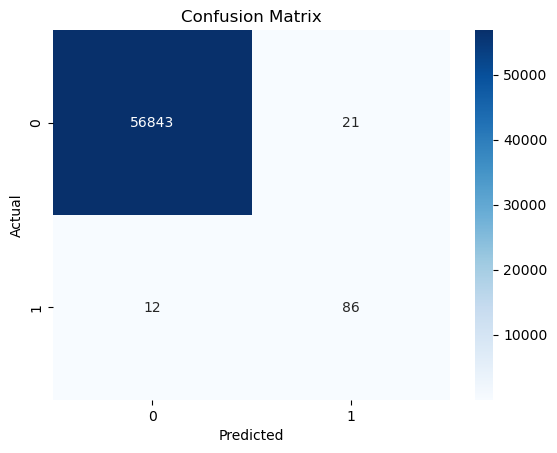

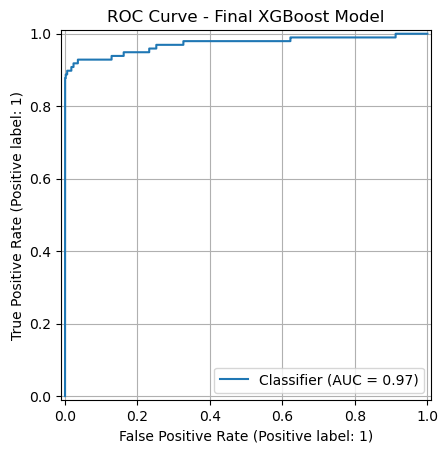

In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred_final)
precision = precision_score(y_test, y_pred_final)
recall = recall_score(y_test, y_pred_final)
f1 = f1_score(y_test, y_pred_final)
roc_auc = roc_auc_score(y_test, y_proba_final)

print("=== Final Optimized Model Performance ===")
print(f"Accuracy     : {accuracy:.6f}")
print(f"Precision    : {precision:.6f}")
print(f"Recall       : {recall:.6f}")
print(f"F1 Score     : {f1:.6f}")
print(f"ROC-AUC Score: {roc_auc:.6f}")

# Optional: Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plot ROC curve
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(y_test, y_proba_final)
plt.title("ROC Curve - Final XGBoost Model")
plt.grid(True)
plt.show()


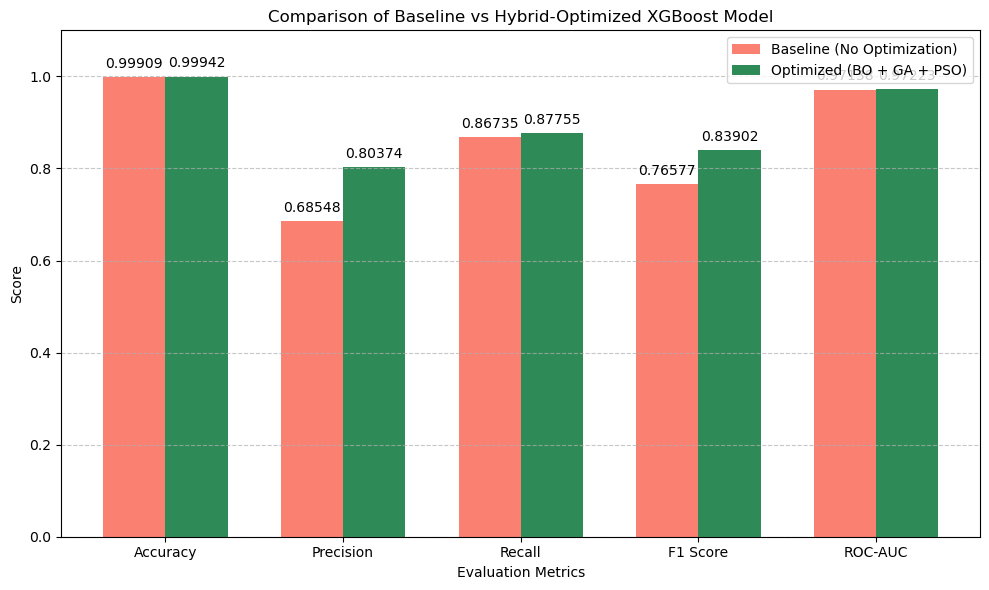

In [70]:
# Baseline (non-optimized) XGBoost model metrics (from uploaded file)
baseline_metrics = {
    'Accuracy': 0.999087,
    'Precision': 0.6854838,
    'Recall': 0.86734693,
    'F1 Score': 0.765765765,
    'ROC-AUC': 0.9713791
}

# Final optimized model metrics (from hybrid optimization step)
optimized_metrics = {
    'Accuracy': accuracy,       # <- from previous cell
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    'ROC-AUC': roc_auc
}
import matplotlib.pyplot as plt
import numpy as np

# Labels and values
metrics = list(baseline_metrics.keys())
baseline_vals = list(baseline_metrics.values())
optimized_vals = list(optimized_metrics.values())

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, baseline_vals, width, label='Baseline (No Optimization)', color='salmon')
plt.bar(x + width/2, optimized_vals, width, label='Optimized (BO + GA + PSO)', color='seagreen')

plt.xlabel('Evaluation Metrics')
plt.ylabel('Score')
plt.title('Comparison of Baseline vs Hybrid-Optimized XGBoost Model')
plt.xticks(x, metrics)
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate values
for i in range(len(metrics)):
    plt.text(x[i] - width/2, baseline_vals[i] + 0.02, f"{baseline_vals[i]:.5f}", ha='center', color='black')
    plt.text(x[i] + width/2, optimized_vals[i] + 0.02, f"{optimized_vals[i]:.5f}", ha='center', color='black')

plt.tight_layout()
plt.show()


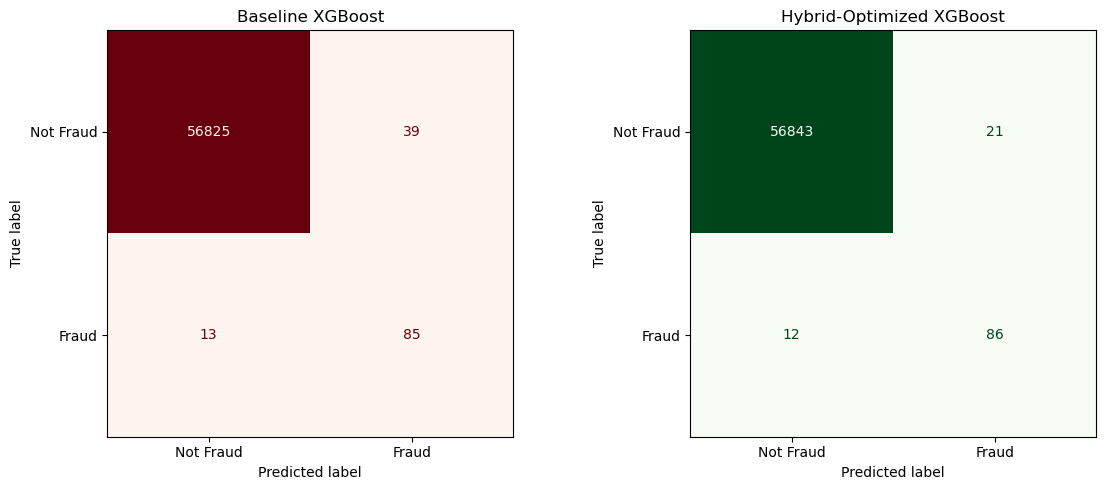

In [72]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# If baseline confusion matrix isn't named, set it manually (based on original notebook)
baseline_cnf_matrix = confusion_matrix(y_test, y_pred_baseline)  # ← example; update if needed
optimized_cnf_matrix = confusion_matrix(y_test, y_pred_final)

# Plotting side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Baseline confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=baseline_cnf_matrix, display_labels=["Not Fraud", "Fraud"])
disp1.plot(ax=axes[0], cmap='Reds', colorbar=False)
axes[0].set_title("Baseline XGBoost")

# Optimized confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=optimized_cnf_matrix, display_labels=["Not Fraud", "Fraud"])
disp2.plot(ax=axes[1], cmap='Greens', colorbar=False)
axes[1].set_title("Hybrid-Optimized XGBoost")

plt.tight_layout()
plt.show()
